# Step 4: Final Model Evaluation

In this notebook I load the final model selected from those trained during Step 3 and evaluate performance based on test data. Model achieves **accuracy of 0.9775 on test data**.

 * Calculate test accuracy
 * Plot confusion matrix
 * Visual inspection of false positives and false negatives
 * Visual inspection of filters for convolution layers

In [57]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from skimage import io
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
# paths
DIR = ('/Users/allankapoor/Documents/Springboard/structure_damage/')
train_path = os.path.join(DIR, 'data', 'train_another')
val_path = os.path.join(DIR, 'data', 'validation_another')
test_path = os.path.join(DIR, 'data', 'test')

In [4]:
# load test data
image_size = (128, 128)
batch_size = 32

# specify test image transformations (rescale only)
test_datagen = ImageDataGenerator(rescale=1./255)

# test images, with shuffle
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')

#test images, no shuffle (so results can be matched to image filenames)
test_generator_noshuff = test_datagen.flow_from_directory(
        test_path,
        target_size=image_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Performance on Test Data

In [113]:
# load best performing model
best_model = load_model('models/Model3/best_model_test.h5')

In [7]:
eval_results = best_model.evaluate(x=test_generator, verbose=1)

63/63 [==============================] - 1s 20ms/step - loss: 0.0806 - accuracy: 0.9775


Best performing model achieves **test accuracy of 0.9775**

## Investigate Misclassifications

In [13]:
def find_missclassed_images(model):
    
    '''Given a model, returns dataframe of missclassified images and confusion matrix'''
    
    # get true labels, predictions
    true_labels = test_generator_noshuff.classes
    predictions = best_model.predict(test_generator_noshuff, verbose=1)
    
    #switching labels to be more intuitive
    y_true = np.array([1 if x==0 else 0 for x in true_labels])
    pred_interim = [np.argmax(x) for x in predictions]
    y_pred = np.array([1 if x==0 else 0 for x in pred_interim])
    
    #y_true = true_labels
    #y_pred = np.array([np.argmax(x) for x in predictions])
    
    #get filenames, create dataframe from dict
    filenames = test_generator_noshuff.filenames
    df_dict = {'filenames':filenames,'true_label':y_true,'pred_label':y_pred}
    df = pd.DataFrame(df_dict)
    misslabelled = df[df['true_label'] != df['pred_label']]
    
    return misslabelled, y_true, y_pred

In [14]:
missclass_df, true, pred = find_missclassed_images(best_model)

63/63 [==============================] - 1s 21ms/step


### Confusion Matrix

The labels correspond to:
 * 0 = NO DAMAGE
 * 1 = DAMAGE
 
(ie damaged is positive class)

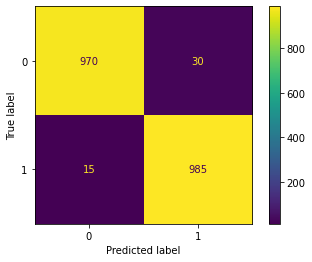

In [15]:
#confusion matrix
ConfusionMatrixDisplay.from_predictions(true, pred);

There are 2x as many false negatives as there are false positives.

### Plot Missclassified Images

In [31]:
# false positive (ie pred=damage(1), true=no damage(0))
fp_list = list(missclass_df[missclass_df.pred_label==1].filenames)

# false negative (ie pred=no damage (0), true=damage(1))
fn_list = list(missclass_df[missclass_df.pred_label==0].filenames)

In [32]:
def create_image_list(filename_list):
    images_list = []
    for filename in filename_list:
        #load  image
        tile_path = os.path.join(DIR, 'data', 'test', filename)
        tile = io.imread(tile_path)
        #add image array to list
        images_list.append(tile)
        
    return images_list

In [33]:
# generate lists of FN/FN image arrays
fp_img_list = create_image_list(fp_list)
fn_img_list = create_image_list(fn_list)

In [34]:
def plot_img_matrix(images_list, rows, columns):

    '''Given a list of image arrays, plot them as tiles in a single figure'''
    f, axarr = plt.subplots(rows,columns, figsize=(columns*2,rows*2))
    img_idx = 0

    for row_idx in range(rows):
        for col_idx in range(columns):

            axarr[row_idx,col_idx].imshow(images_list[img_idx])
            axarr[row_idx,col_idx].axis('off')
            img_idx +=1

    plt.show()

#### False Negatives

Looks like false negatives are mostly larger non-residential structures, have a lot of variation in the ground surface, and/or no obvious flood water.

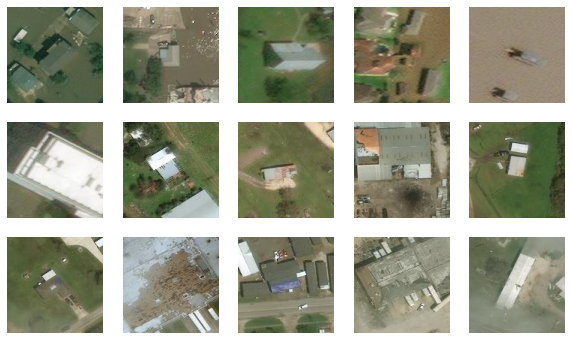

In [96]:
# plot false negative images (predicted as )
plot_img_matrix(fn_img_list, 3, 5)

#### False Positives
These tend to have surfaces that are mistaken for floodwaters or junk around them that is mistaken for damage. False positives appear to also all be rural structures.

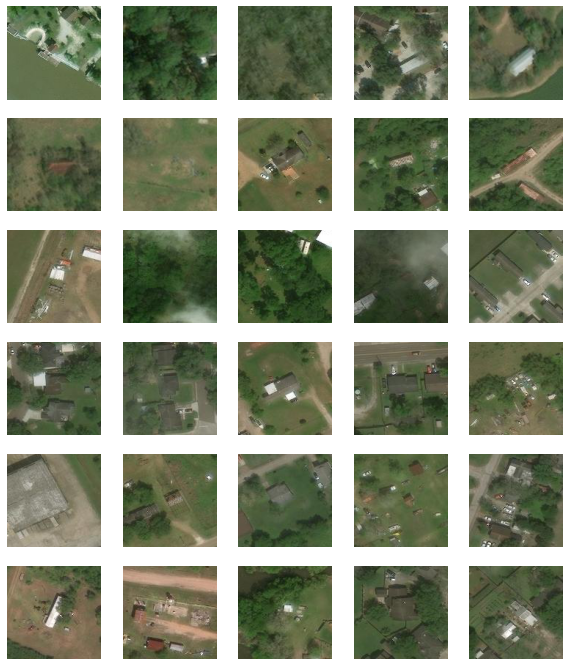

In [101]:
# plot false positive images
plot_img_matrix(fp_img_list, 6, 5)

### Plot Correctly Classified Images

Now let's look at the types of images that the network got right.

In [41]:
def find_correct_images(model):
    
    '''Given a model, returns dataframe of correct images and confusion matrix'''
    
    # get true labels, predictions
    true_labels = test_generator_noshuff.classes
    predictions = best_model.predict(test_generator_noshuff, verbose=1)
    
    #switching labels to be more intuitive
    y_true = np.array([1 if x==0 else 0 for x in true_labels])
    pred_interim = [np.argmax(x) for x in predictions]
    y_pred = np.array([1 if x==0 else 0 for x in pred_interim])
    
    #y_true = true_labels
    #y_pred = np.array([np.argmax(x) for x in predictions])
    
    #get filenames, create dataframe from dict
    filenames = test_generator_noshuff.filenames
    df_dict = {'filenames':filenames,'true_label':y_true,'pred_label':y_pred}
    df = pd.DataFrame(df_dict)
    correct = df[df['true_label'] == df['pred_label']]
    
    return correct, y_true, y_pred

In [47]:
correct_df, a, b = find_correct_images(best_model)

63/63 [==============================] - 1s 21ms/step


In [82]:
# true positive (ie pred=damage(1), true=no damage(1))
tp_list = list(correct_df[correct_df.true_label==1].filenames)
tp_img_list = create_image_list(tp_list)
# shuffle so images plotted are random
random.shuffle(tp_img_list)

# true negative (ie pred=no damage (0), true=damage(0))
tn_list = list(correct_df[correct_df.true_label==0].filenames)
tn_img_list = create_image_list(tn_list)
random.shuffle(tn_img_list)

#### True Positives

Tend to have obvious flood water, or scattered materials. Some of these aren't obvious to the human eye.

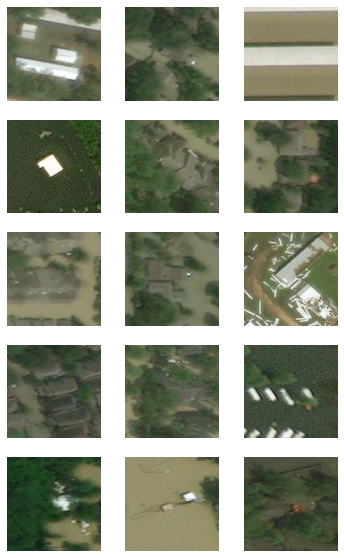

In [102]:
# true positive examples
plot_img_matrix(tp_img_list, 5, 3)

#### True Negatives
Tend to be obviously not flooded (visible ground) - but there are also examples that do have water or surfaces that look like flood water to the human eye.

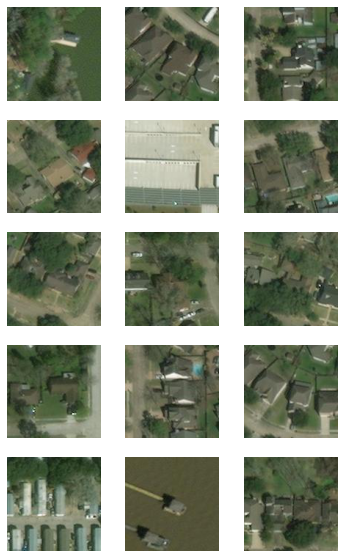

In [103]:
# true negative examples
plot_img_matrix(tn_img_list, 5, 3)

## Visual Inspection of Convolution Filters

In [114]:
best_model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_42 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 16, 16, 64)        0  

In [115]:
img_width = 128
img_height = 128

layer_name = "conv2d_51"

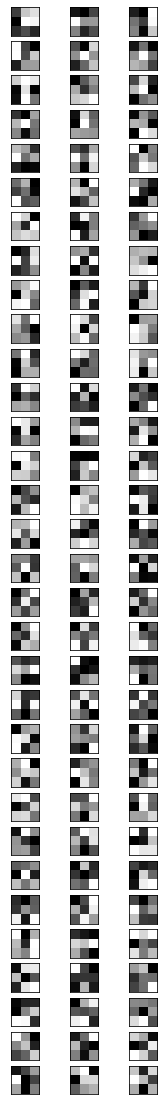

In [117]:
# cannot easily visualize filters lower down
import matplotlib.pyplot as plt

# retrieve weights from the  layer
filters, biases = best_model.get_layer(name=layer_name).get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 32, 1

plt.figure(figsize=(3,20))

for i in range(n_filters):
    
    # get the filter
    f = filters[:, :, :, i]
    
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn off axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1

# show the figure
plt.show()